<a href="https://colab.research.google.com/github/furlancad/PythonFinancas/blob/main/AN%C3%81LISE_FUNDAMENTALISTA_site_analise_macro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
pip install wget # Instala o wget

In [11]:
# Carrega as bibliotecas
import wget # biblioteca para realizar o download de sites
import pandas as pd # biblioteca para manipulação de dados e data frames
from zipfile import ZipFile # biblioteca para extrair arquivo zipados
from plotnine import * # biblioteca para construir o gráfico

In [13]:
def download_extract_concatenate_dfp_files(start_year, end_year, financial_statements):
  """""
Função para realizar o download, extração e concatenação de arquivos zipados contendo os dados da Demonstração Financeira
Padronizada (DFP) de companhias abertas disponibilizados pela Comissão de Valores Mobiliários (CVM).

Parâmetros:
start_year (int): Ano inicial da coleta dos dados.
end_year (int): Ano final da coleta dos dados.
financial_statements (list): Lista de nomes dos arquivos de demonstrativos financeiros que deseja-se concatenar. Consolidado: BPA_con (balanço patrimonial ativo);
BPP_con (Balanço patrimonial passivo) DRE_con; DFC_MI_con; DFC_MD_CON; DMPL_con.

Retorna:
Arquivo .csv no diretório principal
"""""
  # Define a url base dos arquivos zipados
  url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/"

  # Cria uma lista vazia para inserir os nomes dos arquivos zipados
  arquivo_zipado = []

  # Define os nomes dos arquivos zipados de acordo com o range de datas
  for ano in range(start_year, end_year + 1):
    arquivo_zipado.append(f'dfp_cia_aberta_{ano}.zip')

  # Realiza o download dos arquivos zipados de acordo com a url base
  for arquivos in arquivo_zipado:
    wget.download(url + arquivos)

  # Extrai os arquivos zipados
  for arquivos in arquivo_zipado:
    ZipFile(arquivos, 'r').extractall('DFP')

  # Concatena os dados dos demonstrativos financeiros em um único DataFrame
  for demons in financial_statements:
    arquivo_demonstrativo = pd.DataFrame()
    for ano in range(start_year, end_year + 1):
      arquivo_demonstrativo = pd.concat([arquivo_demonstrativo, pd.read_csv(f'DFP/dfp_cia_aberta_{demons}_{ano}.csv', sep = ';', decimal = ',', encoding = 'ISO-8859-1')])
      arquivo_demonstrativo.to_csv(f'dfp_cia_aberta_{demons}_{start_year}-{end_year}.csv', index = False)

In [14]:
# Coleta os dados da DRE
download_extract_concatenate_dfp_files(2010, 2023, ['DRE_con'])

# Realiza a leitura do arquivo
dre = pd.read_csv('dfp_cia_aberta_DRE_con_2010-2023.csv')

In [15]:
# Realiza o filtro das contas contábeis, do código CVM e da ordem do exercício
dados = dre[dre.CD_CONTA.isin([
    "3.01", # Receita de Venda de Bens e/ou Serviços
    "3.03", # Resultado Bruto
    "3.05", # EBIT
    "3.11" # Lucro/Prejuízo Consolidado do Período
]) & dre.CD_CVM.isin([1023, 4170, 9512, 2453]) & (dre.ORDEM_EXERC == 'ÚLTIMO')]
# Seleciona as colunas
dados = dados[["DT_REFER", "DENOM_CIA", "CD_CONTA", "DS_CONTA", "VL_CONTA"]]

# Converte a coluna de data para datetime
dados['DT_REFER'] = pd.to_datetime(dados['DT_REFER'])

# Cria a coluna Ano
dados['Ano'] = dados['DT_REFER'].dt.year

dados_pivot = dados.pivot(index = ['Ano', 'DENOM_CIA'], columns = 'CD_CONTA', values = 'VL_CONTA')
dados_pivot.head()

CD_CONTA                                            3.01        3.03  \
Ano  DENOM_CIA                                                         
2010 BCO BRASIL S.A.                          85143206.0  34367465.0   
     CIA ENERGETICA DE MINAS GERAIS - CEMIG   12863330.0   4565759.0   
     PETROLEO BRASILEIRO S.A. PETROBRAS      213273669.0  77221840.0   
     VALE S.A.                                83225007.0  49468940.0   
2011 BCO BRASIL S.A.                         106919760.0  36943685.0   

CD_CONTA                                           3.05        3.11  
Ano  DENOM_CIA                                                       
2010 BCO BRASIL S.A.                         16550866.0         NaN  
     CIA ENERGETICA DE MINAS GERAIS - CEMIG   3646795.0   2257976.0  
     PETROLEO BRASILEIRO S.A. PETROBRAS      45574588.0  35901445.0  
     VALE S.A.                               40442258.0  30421492.0  
2011 BCO BRASIL S.A.                         17795255.0         NaN

In [16]:
# Cria os indicadores
indicadores = (
dados_pivot.assign(
    margem_bruta = (dados_pivot["3.03"]) / dados_pivot["3.01"] * 100,
    margem_liquida = (dados_pivot["3.11"]) / dados_pivot["3.01"] * 100,
    margem_ebit = (dados_pivot["3.05"]) / dados_pivot["3.01"] * 100)
)

# Retira o índice
indicadores.reset_index(inplace = True)


# Arrendonda os valores
indicadores = indicadores.round(decimals = 3)

# Seleciona colunas e arredonda valores
indicadores = indicadores[['Ano', 'DENOM_CIA', 'margem_bruta', 'margem_liquida', 'margem_ebit']].round(decimals = 3)
indicadores_long = indicadores.melt(id_vars = ['Ano', 'DENOM_CIA'], var_name = "Indicadores")

indicadores_long

,Ano,DENOM_CIA,Indicadores,value
0,2010,BCO BRASIL S.A.,margem_bruta,40.364
1,2010,CIA ENERGETICA DE MINAS GERAIS - CEMIG,margem_bruta,35.494
2,2010,PETROLEO BRASILEIRO S.A. PETROBRAS,margem_bruta,36.208
3,2010,VALE S.A.,margem_bruta,59.440
4,2011,BCO BRASIL S.A.,margem_bruta,34.553
...,...,...,...,...
163,2022,VALE S.A.,margem_ebit,39.878
164,2023,BCO BRASIL S.A.,margem_ebit,15.502
165,2023,CIA ENERGETICA DE MINAS GERAIS - CEMIG,margem_ebit,19.621
166,2023,PETROLEO BRASILEIRO S.A. PETROBRAS,margem_ebit,36.981


/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


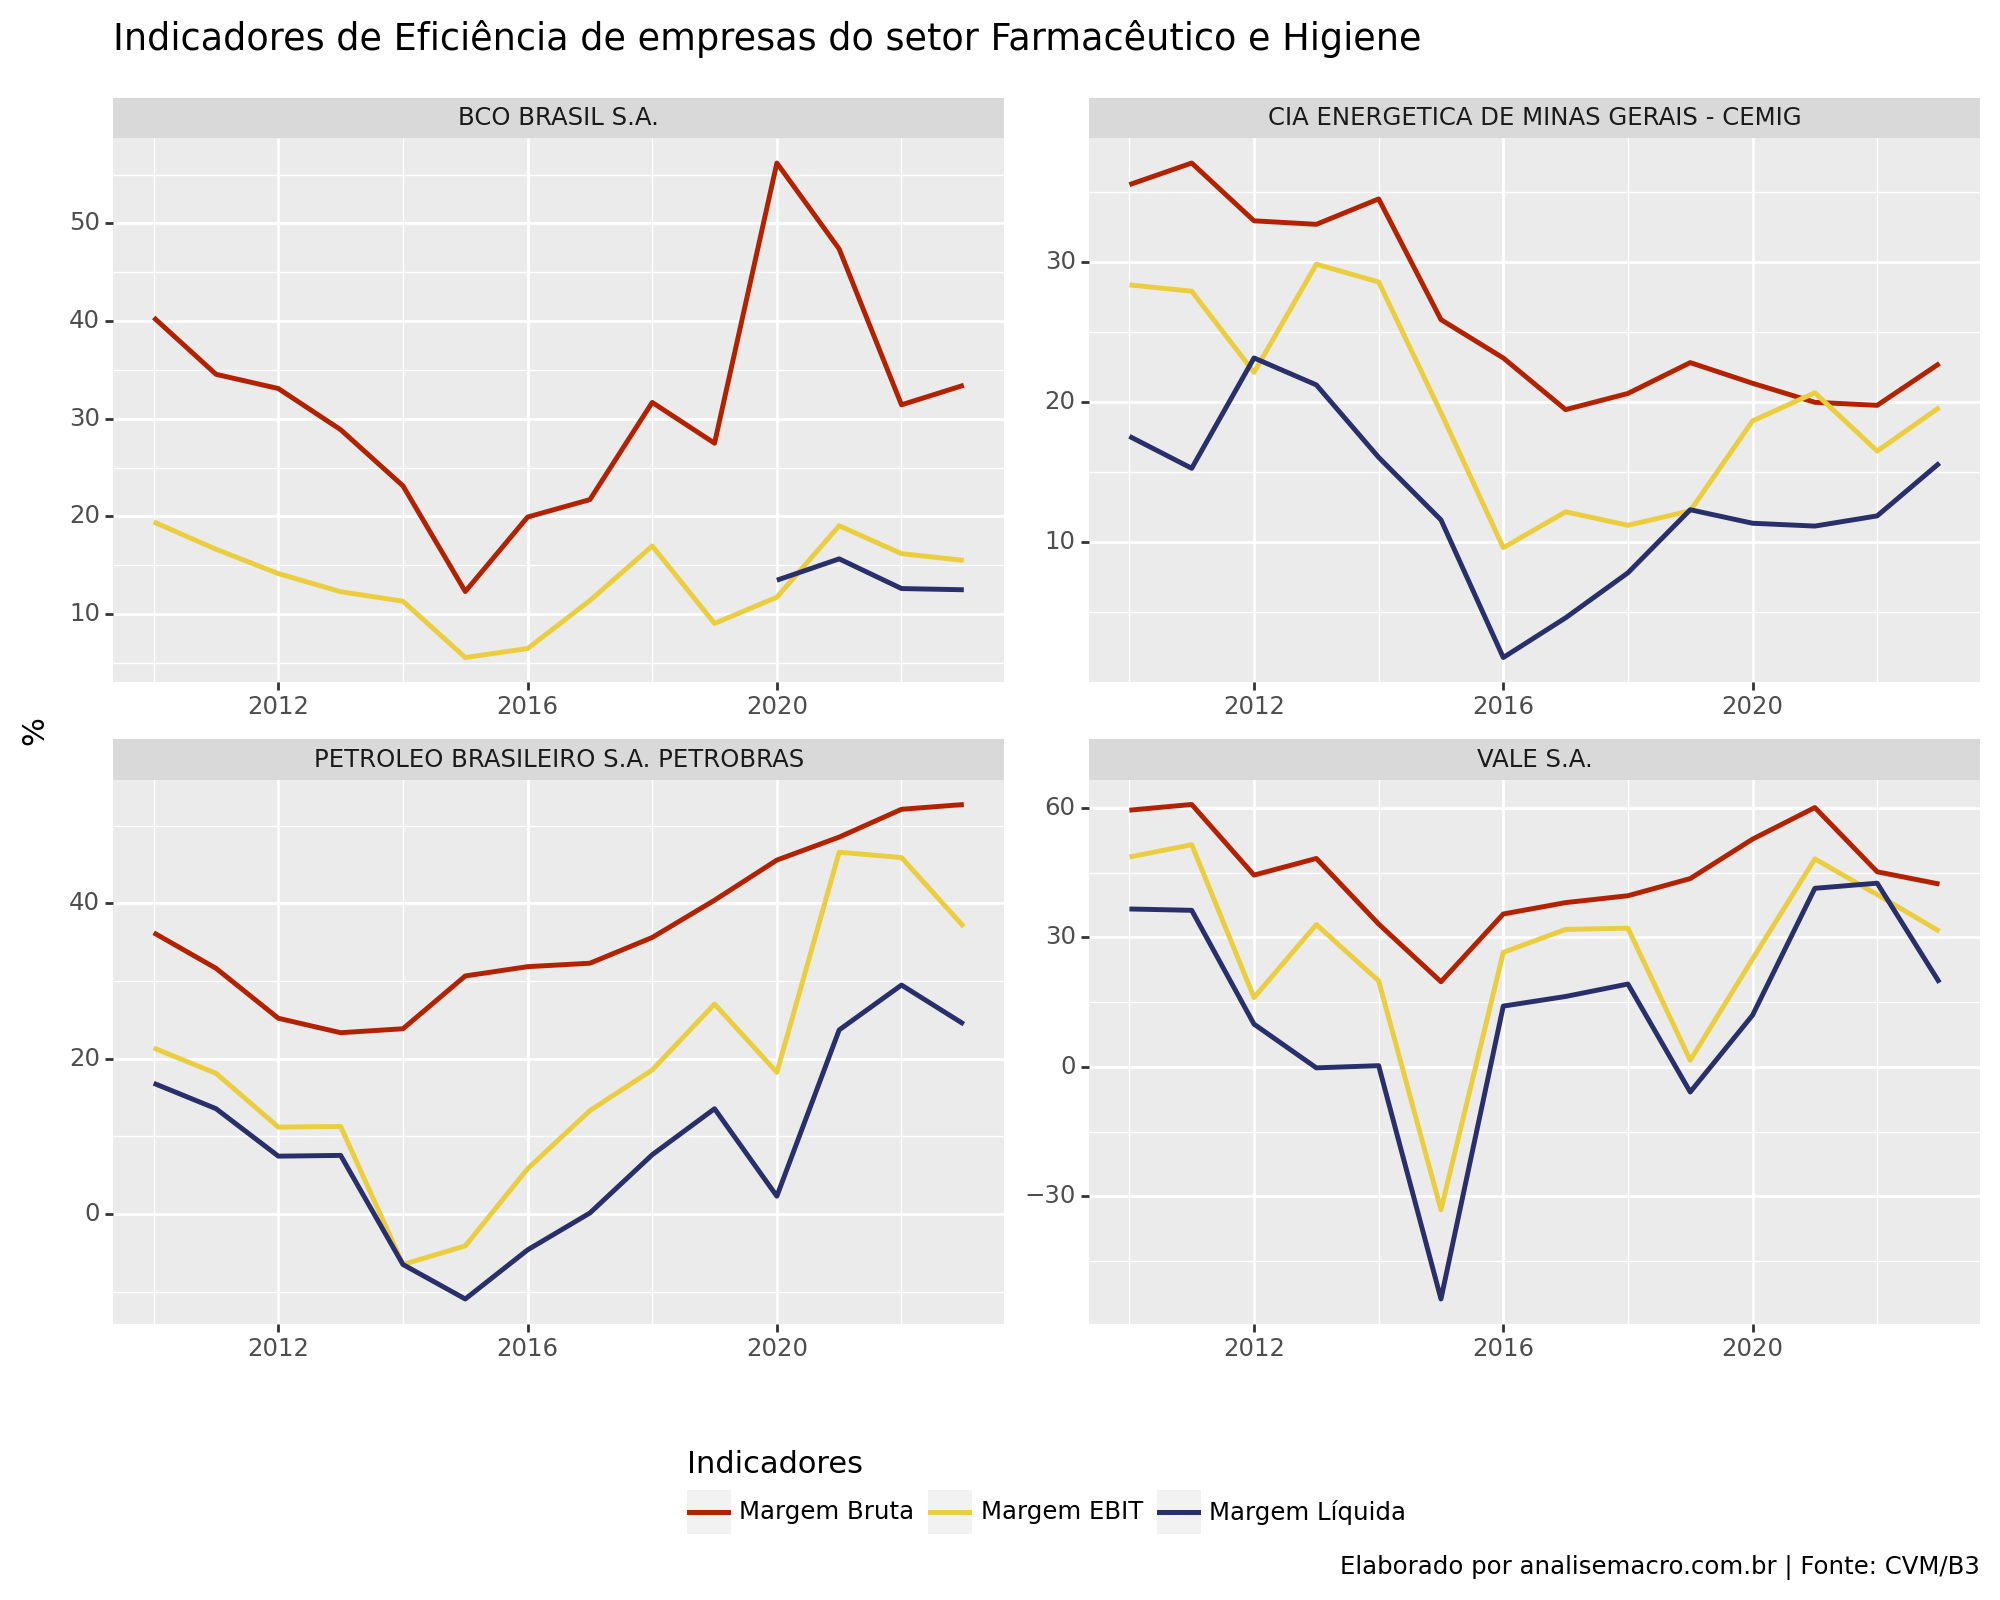

<Figure Size: (1000 x 800)>

In [17]:
# Criando o gráfico
(
ggplot(indicadores_long, aes(x = "Ano",
y = "value",
color = "Indicadores"))
+ geom_line(size = 1)
+ facet_wrap("DENOM_CIA", scales = "free")
+ scale_color_manual(values = {'margem_liquida' : '#282f6b', 'margem_bruta' : "#b22200", 'margem_ebit' : "#eace3f"},
labels = {'margem_liquida' : 'Margem Líquida', 'margem_bruta' : 'Margem Bruta', 'margem_ebit' : 'Margem EBIT'})
+ labs(title = "Indicadores de Eficiência de empresas do setor Farmacêutico e Higiene",
y = '%',
x = '',
caption = "Elaborado por analisemacro.com.br | Fonte: CVM/B3")
+ theme(figure_size=(10, 8),
subplots_adjust = {'wspace': 0.25,
'hspace': 0.25},
legend_position = 'bottom')
)

In [18]:
indicadores[DENOM_CIA]

NameError: name 'DENOM_CIA' is not defined

In [ ]:
dados_pivot